In [1]:
import sys

sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")

In [2]:
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [3]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections
import sys
sys.path.insert(0, '../')
from config.eval.cifar10 import get_config as get_eval_config
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = get_eval_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

def imgtrans(x):
    x = np.transpose(x, (1,2,0))
    return x

In [4]:
# -------------- Sample the model ------------------
num_samples = 10

# Change the sampler name of eval config (sneaky!)
eval_cfg.sampler.name = "PCTauLeapingMPF"

sampler = sampling_utils.get_sampler(eval_cfg)
samples, x_hist, x0_hist = sampler.sample(model, num_samples, 10)

samples = samples.reshape(num_samples, 3, 32, 32)
x_hist = x_hist.reshape(10, num_samples, 3, 32, 32)
x0_hist = x0_hist.reshape(10, num_samples, 3, 32, 32)

499it [00:17, 28.10it/s]


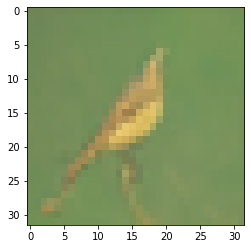

In [15]:
# ------------- Display the sample ------------
idx = 2
plt.imshow(imgtrans(samples[idx, ...]))
plt.show()

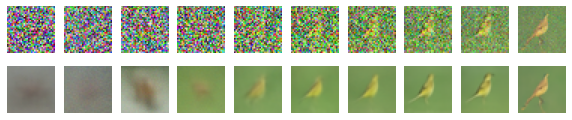

In [16]:
# --------------- Display the progression during sampling -----------
# first row is the progression of the sample itself
# second row is the progression of the x0 predictions
# idx = 1
fig, ax = plt.subplots(2, 10)
for i in range(10):
    ax[0, i].imshow(imgtrans(x_hist[i, idx, ...]))
    ax[0, i].axis('off')
    ax[1, i].imshow(imgtrans(x0_hist[i, idx, ...]))
    ax[1, i].axis('off')
plt.gcf().set_size_inches(10, 2)
plt.show()

# Sanity check: total number of parameters

In [7]:
total_params = sum(p.numel() for p in model.parameters())

In [8]:
total_params

35749766

In [9]:
model.parameters()

<generator object Module.parameters at 0x7f1533f3e890>

In [10]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Total number of trainable parameters: {trainable_params}")
print(f"Total number of non-trainable parameters: {non_trainable_params}")

Total number of trainable parameters: 35749766
Total number of non-trainable parameters: 0
